In [51]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import seaborn as sns
sns.set_context('notebook')
from sklearn.neighbors import NearestNeighbors
from PIL import Image

In [52]:
def show_galaxies(df, n_galaxies=36, label=None):
    if n_galaxies == 8:
        fig, all_axes = plt.subplots(1, 8, figsize=(20, 3.5))
    elif n_galaxies == 11:
        fig, all_axes = plt.subplots(1, 11, figsize=(20, 4.5))
    elif n_galaxies == 12:
        fig, axes = plt.subplots(2, 6, figsize=(20, 7))
        all_axes = [ax for row in axes for ax in row]
    else:
        fig, axes = plt.subplots(6, 6, figsize=(20, 20))
        all_axes = [ax for row in axes for ax in row]
    for ax_n, ax in enumerate(all_axes):
        im = Image.open(os.path.join('/media/walml/beta1/decals/png_native/dr5', df.iloc[ax_n]['png_loc']))
        
        crop_pixels = 120
        initial_size = 424 # assumed, careful
        (left, upper, right, lower) = (crop_pixels, crop_pixels, initial_size-crop_pixels, initial_size-crop_pixels)
        im = im.crop((left, upper, right, lower))

        ax.imshow(np.array(im))
        
        if ax_n == 0:
            ax.patch.set_edgecolor('green')  
            ax.patch.set_linewidth('14')  
            # can't just disable axis as also disables border, do manually instead
            ax.xaxis.set_major_locator(ticker.NullLocator())
            ax.xaxis.set_minor_locator(ticker.NullLocator())
            ax.yaxis.set_major_locator(ticker.NullLocator())
            ax.yaxis.set_minor_locator(ticker.NullLocator())
            if label:
                ax.set_ylabel(label, labelpad=7, fontsize=14)
        else:
            ax.axis('off')
            
    fig.tight_layout(pad=1.)
    
    return fig

## Load the color embedding

In [53]:
n_components = 10

pca_df = pd.read_parquet('/home/walml/repos/zoobot/data/results/dr5_color_pca{}_and_ids.parquet'.format(n_components)).reset_index()
embed_cols = [col for col in pca_df if 'feat_' in col]
print(len(pca_df))

343128


In [54]:
catalog_df = pd.read_parquet('/media/walml/beta1/galaxy_zoo/decals/catalogs/dr5_nsa_v1_0_0_to_upload.parquet', columns=['iauname', 'png_loc'])
catalog_df = catalog_df.rename(columns={'iauname': 'galaxy_id'})
pca_df = pd.merge(pca_df, catalog_df, on='galaxy_id', how='inner').reset_index()
print(len(pca_df))

343128


## Or, load the greyscale version (needs manual embed)

In [33]:
df = pd.read_parquet('/media/walml/beta1/cnn_features/decals/dr5_b0_full_features_and_safe_catalog.parquet')
wrong_size = pd.read_parquet('/home/walml/repos/zoobot_private/gz_decals_volunteers_auto_posteriors_wrongsize.parquet', columns=['iauname', 'wrong_size_statistic', 'wrong_size_warning'])
print(len(df))
df = pd.merge(df, wrong_size, on='iauname', how='inner')
print(len(df))
df = df[~df['wrong_size_warning']]
df = df.reset_index()

305657
273722


In [34]:
from sklearn.decomposition import IncrementalPCA
import pickle

def get_embed(features, n_components, save=''):
    embedder = IncrementalPCA(n_components=n_components)
    embed = embedder.fit_transform(features) 
     # no train/test needed as unsupervised
    if len(save) > 0:
        plt.plot(embedder.explained_variance_)  # 5 would probably do?
        plt.savefig(save)
        plt.close()
    return embed

feature_cols = [col for col in df if 'feat_' in col]
features = df[feature_cols].values


In [35]:
n_components = 10

In [36]:
# X = get_embed(features, n_components=n_components)
# with open('pc{}_embed_for_similarity_nb.pickle'.format(n_components), 'wb') as f:
#     pickle.dump(X, f)

In [37]:
with open('pc{}_embed_for_similarity_nb.pickle'.format(n_components), 'rb') as f:
    embed = pickle.load(f)

In [38]:
pca_df = pd.DataFrame(data=embed, columns=['feat_{}_pca'.format(n) for n in range(n_components)])
pca_df['galaxy_id'] = df['iauname']
pca_df['png_loc'] = df['png_loc']

In [55]:
tags_df = pd.read_csv('/home/walml/repos/recommender_hack/tags_for_shoaib.csv')
print(len(tags_df))
tags_df = tags_df[tags_df['iauname'].isin(pca_df['galaxy_id'])]
print(len(tags_df))

110764
109957


In [56]:
join = {
    'star-forming': 'starforming',
    'starformation': 'starforming',
    'lenticular-galaxy': 'lenticular', 
    'ringed': 'ring',
    'interacting': 'interaction',
    'disturbance': 'disturbed',
    'bright-core': 'core',
    'dusty': 'dust',
    'foreground-star': 'star',
    'central-core': 'core'
}

# pairs_to_replace = [
#     ('star-forming', 'starforming'),
#     ('starburst', 'starforming'),
#     ('starformation', 'starforming'),
#     ('dust-lane', 'dustlane'),
#     ('dust', 'dustlane'),
#     ('dusty', 'dustlane'),
#     ('edge-on', 'edgeon'),
#     ('seyfert-1-galaxy', 'seyfert-1'),
#     ('interaction', 'interacting'),
#     ('overlapping-object', 'overlap'),
#     ('overlapping', 'overlap'),
#     ('central-core', 'core'),
#     ('ringed', 'ring'),
#     ('wrong_size', 'wrong-size'),
#     ('tidal-debris', 'tidal'),
#     ('objects_that_need_more_research', 'need_more_research')
# ]

for old, new in join.items():
    tags_df['tag_clean'] = tags_df['tag'].str.replace(old, new)

In [57]:
# ml_df = pd.read_parquet('TODO')

### Clean up tags

In [58]:
tags_df['tag_clean'].value_counts()[:40]

starforming                        10228
spiral                              7652
agn                                 6944
starburst                           5033
disturbed                           3953
ring                                3147
merger                              2579
edge-on                             2498
bar                                 2387
overlap                             2119
barred-spiral                       2088
decals                              2058
sdss                                1855
irregular                           1786
star-forming                        1233
dustlane                            1056
asteroid                             957
elliptical                           954
broadline                            688
merging                              608
dust-lane                            592
spiral2                              588
hot                                  584
h-alpha-peak                         583
tidal           

In [59]:
tags_df['tag_clean'].value_counts()[40:80]

radio-galaxy          375
seyfert-1-galaxy      363
seyfert-1             359
edgeon                348
star                  342
strong-bar            331
main-belt             324
fuzzy-disk            323
barlens               314
fuzzy-spiral          294
clumpy                292
group                 268
barred                265
radio-source          263
seyfert-2             262
smooth                261
red-galaxy            260
seyfert-2-galaxy      248
disk                  246
ansae                 243
overlapping-star      243
interaction           242
blue                  239
qso                   239
lenticular-galaxy     238
spiral-2              232
beautiful             231
interacting           231
ringed                225
overlapping-object    220
fuzzy                 218
disturbance           209
bright-core           207
green                 206
interesting           205
dusty                 204
foreground-star       202
faint                 202
tidal-tail  

In [60]:
skip_q = ['spiral', 'edge-on', 'bar', 'barred-spiral', 'elliptical', 'spiral2', 'galaxy', 'edgeon', 'strong-bar', 'barred', 'smooth', 'spiral-2']
skip_meta = ['decals', 'sdss', 'broadline', 'agn', 'staburst', 'h-alpha-peak', 'infra-red-source', 'liner-type-agn', 'emission-line-galaxy', 'radio_galaxy', 'seyfert-1-galaxy', 'seyfert-1', 'radio-source', 'seyfert-2', 'disk', 'seyfert-2-galaxy', 'qso', 'radio-galaxy']
skip_color = ['red-galaxy', 'red', 'blue', 'green']

# wavelength_tags = ['agn', 'seyfert-1', 'infra-red-source', 'liner-type-agn', 'radio_galaxy', 'seyfert-2', 'seyfert-2-galaxy', 'red-galaxy', 'radio-source', 'blue', 'green', 'qso', 'emission-line-galaxy', 'radio-galaxy', 'h-alpha-peak', 'broadline']
# question_tags = ['spiral', 'edgeon', 'elliptical', 'merger', 'bar', 'barred-spiral', 'merging', 'spiral2', 'spiral-2', 'strong-bar', 'barred', 'smooth', 'disk', 'disturbance']
# metadata_tags = ['decals', 'sdss', 'galaxy']
# duplicate_tags = ['fuzzy', 'overlapping-star', 'main-belt']

# tags_to_skip = wavelength_tags + question_tags + metadata_tags + duplicate_tags

tags_to_skip = set(skip_q).union(set(skip_meta)).union(set(skip_color))
top_tags = [tag for tag in list(tags_df['tag_clean'].value_counts().index) if tag not in tags_to_skip][:50]

In [61]:
top_tags

['starforming',
 'starburst',
 'disturbed',
 'ring',
 'merger',
 'overlap',
 'irregular',
 'star-forming',
 'dustlane',
 'asteroid',
 'merging',
 'dust-lane',
 'hot',
 'tidal',
 'artifact',
 'overlapping',
 'lenticular',
 'core',
 'tidal-debris',
 'starformation',
 'diffuse',
 'dust',
 'wrong_size',
 'wrong-size',
 'objects_that_need_more_research',
 'star',
 'main-belt',
 'fuzzy-disk',
 'barlens',
 'fuzzy-spiral',
 'clumpy',
 'group',
 'ansae',
 'overlapping-star',
 'interaction',
 'lenticular-galaxy',
 'beautiful',
 'interacting',
 'ringed',
 'overlapping-object',
 'fuzzy',
 'disturbance',
 'bright-core',
 'interesting',
 'dusty',
 'foreground-star',
 'faint',
 'tidal-tail',
 'debris',
 'overlapping-galaxy']

### Count tags

In [62]:
tag_counts_by_iauname = {}

for tag in top_tags:
    tag_counts_this_tag = tags_df.query(f'tag == "{tag}"').groupby('iauname').agg({'tag': 'count'}).reset_index()
    tag_counts_by_iauname[tag] = tag_counts_this_tag

In [63]:
top_galaxy_by_tag = {}
for tag, iauname_counts in tag_counts_by_iauname.items():
    top_galaxy_by_tag[tag] = list(iauname_counts.sort_values('tag')['iauname'])[-1]

### Search for those galaxies

In [64]:
def get_neighbors(X, query_index, n_neighbors, metric):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree', metric=metric).fit(X)
    distances, indices = nbrs.kneighbors(X[query_index].reshape(1, -1))
#     print(something)
    return np.squeeze(indices)  # ordered by similarity, will include itself

In [65]:
max_galaxies = 8
embed_cols = [col for col in pca_df if 'feat_' in col]
embedding = pca_df[embed_cols].values

for tag_n, tag in enumerate(top_tags[:10]):
#     print(top_galaxy_by_tag[tag])
    galaxy_index = np.argmax(pca_df['galaxy_id'] == top_galaxy_by_tag[tag])
    assert galaxy_index # != 0
    indices = get_neighbors(embedding, galaxy_index, n_neighbors=max_galaxies, metric='euclidean')
#     print(indices)
#     break
    tag_label = f'"{tag.capitalize()}

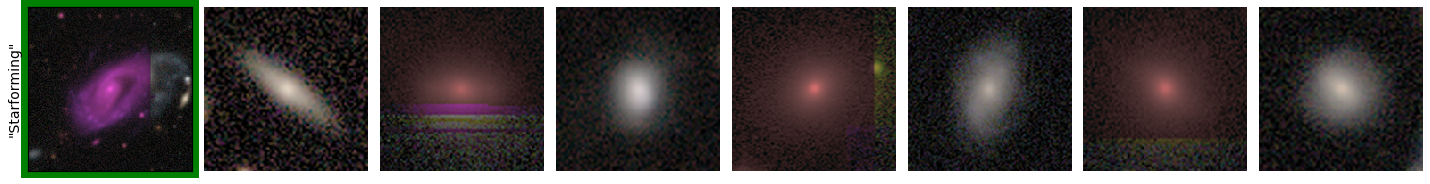

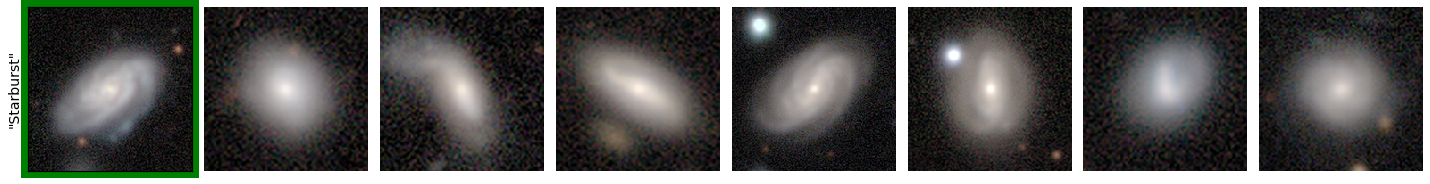

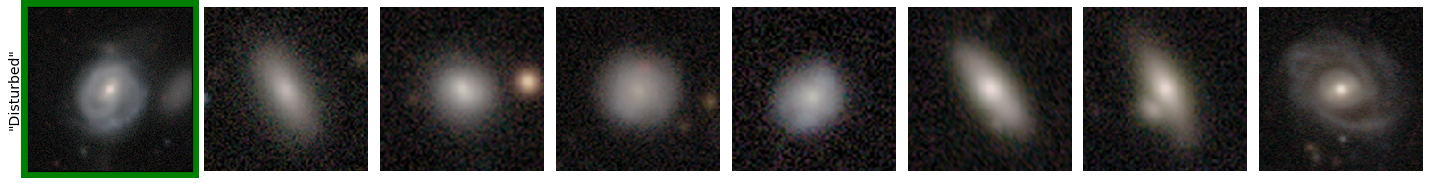

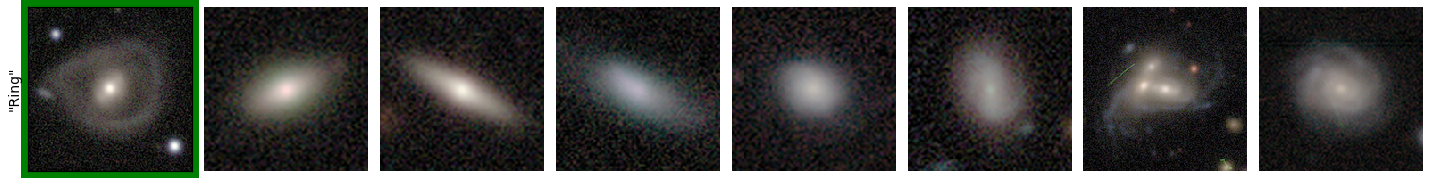

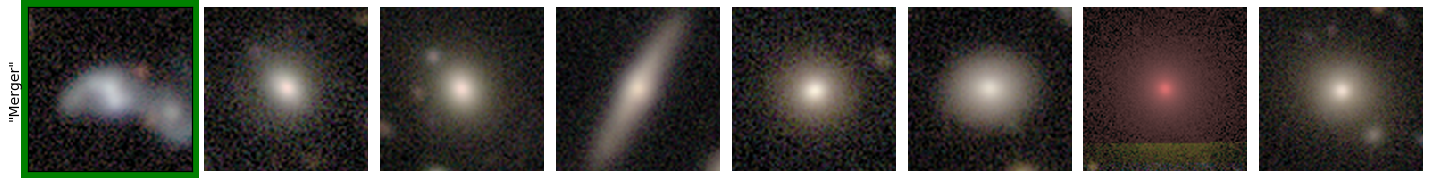

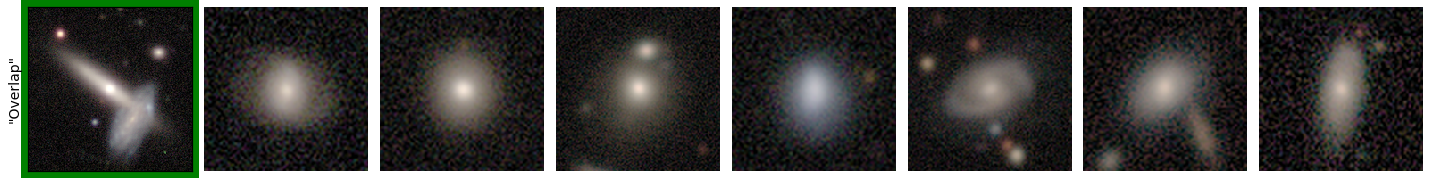

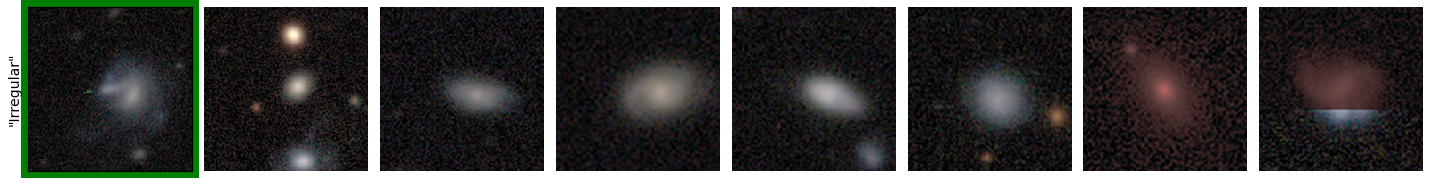

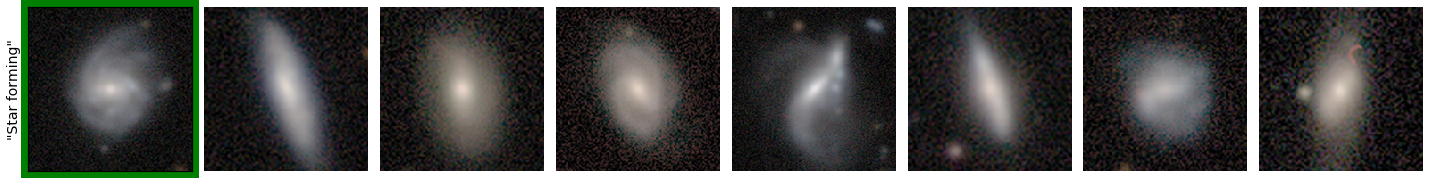

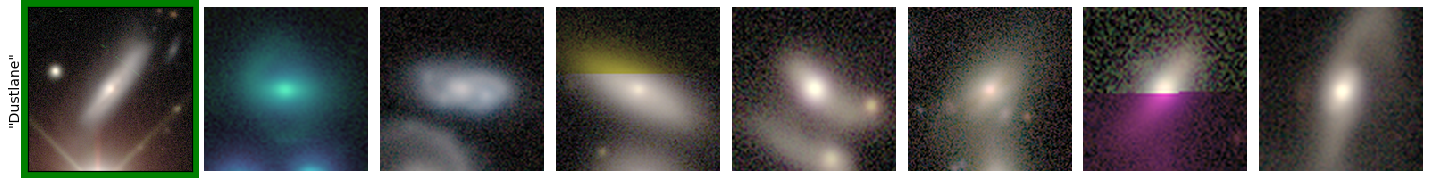

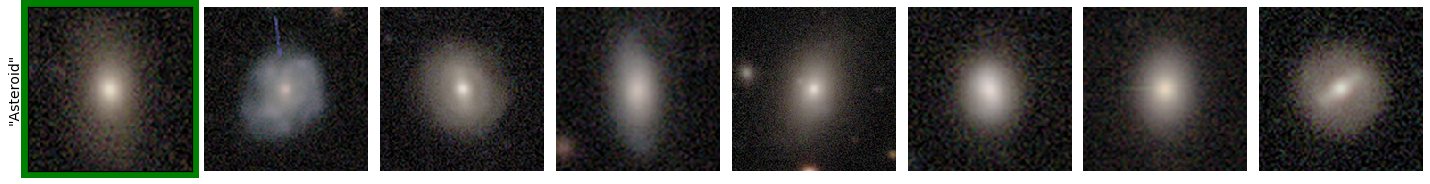

In [65]:
"'.replace('-', ' ').replace('_', ' ')
    fig = show_galaxies(pca_df.iloc[np.squeeze(indices)], n_galaxies=max_galaxies, label=tag_label)  # first is itself
#     fig.savefig(f'similar/pca10/similar_{tag_n}_tag_{tag}_n{n_galaxies}_pca10_talk.png'.format(n_galaxies))
#     fig.savefig(f'similar/features/similar_tag_{tag}_n{n_galaxies}_features.png'.format(n_galaxies))
#     plt.close()

In [50]:
assert False

AssertionError: 

In [ ]:
index_0 = 167864
index_1 = 110058

In [ ]:
embedding[index_0]

In [ ]:
embedding[index_1]

In [ ]:
distances = np.zeros(len(embedding))
for n, index in enumerate(range(len(embedding))):
    distances[n] = np.sum(np.sqrt(np.abs(embedding[index_1] ** 2 - embedding[index] ** 2)))

In [ ]:
np.argsort(distances)[:5]

In [ ]:
np.sum(np.sqrt(np.abs(embedding[index_1] ** 2 - embedding[168590] ** 2)))

In [ ]:
# show_galaxies(pca_df.iloc[np.argsort(distances)[:5]])

In [ ]:

# for tag in top_tags:
#     iauname = top_galaxy_by_tag[tag]
#     query_index = np.argmax(pca_df['galaxy_id'] == iauname)
#     neighbor_indices = get_neighbors(pca_df[feature_cols].values, query_index, n_neighbors=max_galaxies, metric='manhattan')
#     fig = show_galaxies(pca_df.iloc[neighbor_indices])
    
#     tag_label = f'"{tag.capitalize()}"'.replace('-', ' ').replace('_', ' ')
#     fig = show_galaxies(pca_df.iloc[np.squeeze(indices)], n_galaxies=n_galaxies, label=tag_label)  # first is itself
#     fig.savefig(f'similar/pca10/similar_{tag_n}_tag_{tag}_n{n_galaxies}_pca10_talk.png'.format(n_galaxies))
# #     fig.savefig(f'similar/features/similar_tag_{tag}_n{n_galaxies}_features.png'.format(n_galaxies))
# #     plt.close()